In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import colors
import matplotlib.ticker as ticker
import os
import json
import sys
sys.path.append('..')
sys.path.append('../lib')
from lib import *
plt.style.use('../peptidome.mplstyle')
import logging
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_curve
from sklearn.manifold import MDS


## For original analyses and creation of the dkl data see https://github.com/andim/peptidome/blob/master/code/maxent/

In [2]:
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
k = 9

In [3]:
proteomes = ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses', 'Malaria', 'Tuberculosis', 'Listeria', 'StrepA', ]

dkls = pd.DataFrame(data={ model:
                          [float(pd.read_csv(f'../data/generated_data/{proteome}_{model}_k{k}_dkl.csv',header=1)['Human'].values[0])
                            if not proteome == 'Human' else 0.0 for proteome in proteomes]
                          for model in models}
                    , index=proteomes)
dkls

,independent,ncov,nskew,nskewfcov
Human,0.000000,0.000000,0.000000,0.000000
Mouse,0.002253,0.004042,0.005105,0.008254
Chicken,0.004015,0.009402,0.015382,0.028639
Zebrafish,0.027247,0.033611,0.037151,0.050833
Humanviruses,0.088965,0.116080,0.132840,0.174851
Malaria,2.187526,1.728773,1.812532,2.021635
Tuberculosis,0.683733,0.628935,0.669782,0.753602
Listeria,0.431979,0.432895,0.439497,0.504251
StrepA,0.373067,0.379449,0.389560,0.483227


In [4]:
Sind = np.log(naminoacids)*k
dkls_rand = pd.DataFrame(data={ model:
                          [Sind - float(pd.read_csv(f'../data/generated_data/{proteome}_{model}_k{k}_entropy.csv',
                                            index_col=0, header=None).loc['S'].values[0])
                            for proteome in proteomes]
                          for model in models}
                    , index=proteomes)
dkls_rand

,independent,ncov,nskew,nskewfcov
Human,0.921306,1.047240,1.094034,1.142509
Mouse,0.903164,1.009821,1.053955,1.106401
Chicken,0.870244,1.002373,1.046072,1.085164
Zebrafish,0.826642,0.910718,0.962889,1.002249
Humanviruses,0.840005,1.029027,1.088281,1.122798
Malaria,2.073610,2.287159,2.326683,2.481378
Tuberculosis,1.871207,1.956671,2.009185,2.093849
Listeria,1.210196,1.252900,1.292349,1.361428
StrepA,1.190008,1.234220,1.269707,1.362927


In [5]:
def mscatter(x,y, ax=None, m=None, **kwargs):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x, y, **kwargs)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        legend_handles = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
            legend_handles.append(Line2D([0], [0], marker=marker, ls=''))
        sc.set_paths(paths)
    return sc, legend_handles

In [6]:
def plot_lineandscatter(x, y, label=None, ax=None, markers=['o', 's', '>', 'd']):
    if not ax:
        ax = plt.gca()
    l, = ax.plot(x, y, ls='-', label=label)
    sc, legend_handles = mscatter(x, y, m=markers, ax=ax, s=10)
    return l, sc, legend_handles

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1389692/2038790992.py:9: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$D_{KL}$(proteome $\parallel$ human)')
/tmp/ipykernel_1389692/2038790992.py:10: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$D_{KL}$(proteome $\parallel$ uniform)')


Text(0, 0.5, '$D_{KL}$(proteome $\\parallel$ uniform)')

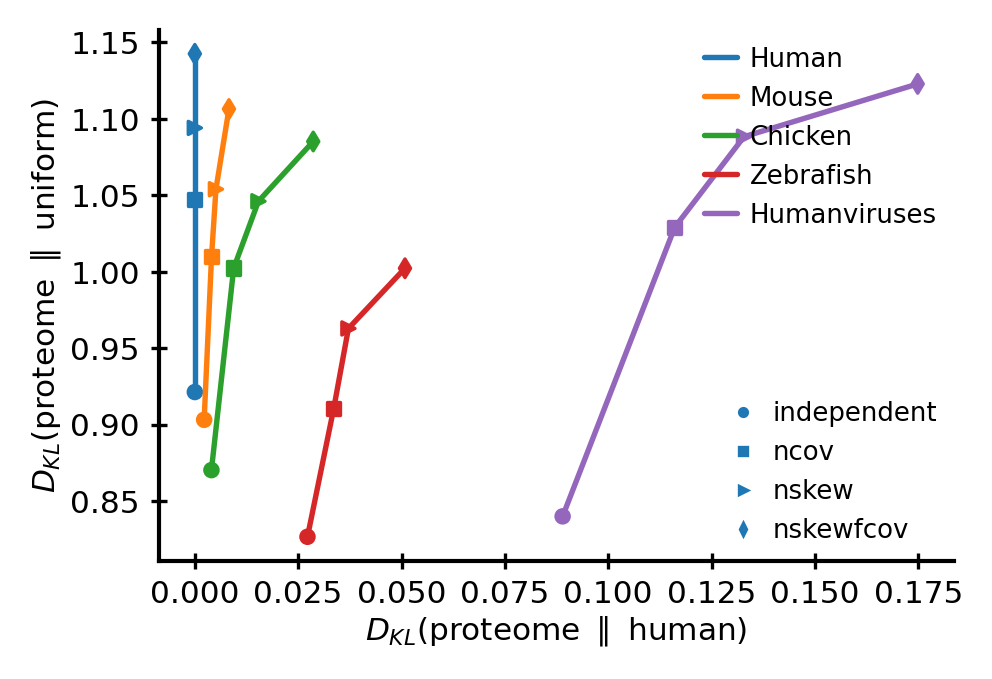

In [7]:
fig, ax = plt.subplots()
logging.getLogger('matplotlib.font_manager').disabled = True

for proteome in ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses']:
    l, sc, legend_handles = plot_lineandscatter(dkls.loc[proteome], dkls_rand.loc[proteome], label=proteome)
l1 = ax.legend(ncol=1, loc='upper right')
l2 = ax.legend(legend_handles, models)
ax.add_artist(l1)
ax.set_xlabel('$D_{KL}$(proteome $\parallel$ human)')
ax.set_ylabel('$D_{KL}$(proteome $\parallel$ uniform)')

In [8]:
class smart_dict(dict):
    def __missing__(self, key):
        return key
proteome_to_label = smart_dict()
proteome_to_label['Humanviruses'] = 'Human Virome'
proteome_to_label['Malaria'] = 'P. falciparum'

<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1389692/3986492207.py:17: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$D_{KL}$(Proteome $\parallel$ Human Proteome) in bits')
/tmp/ipykernel_1389692/3986492207.py:18: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$D_{KL}$(Proteome $\parallel$ Uniform) in bits')


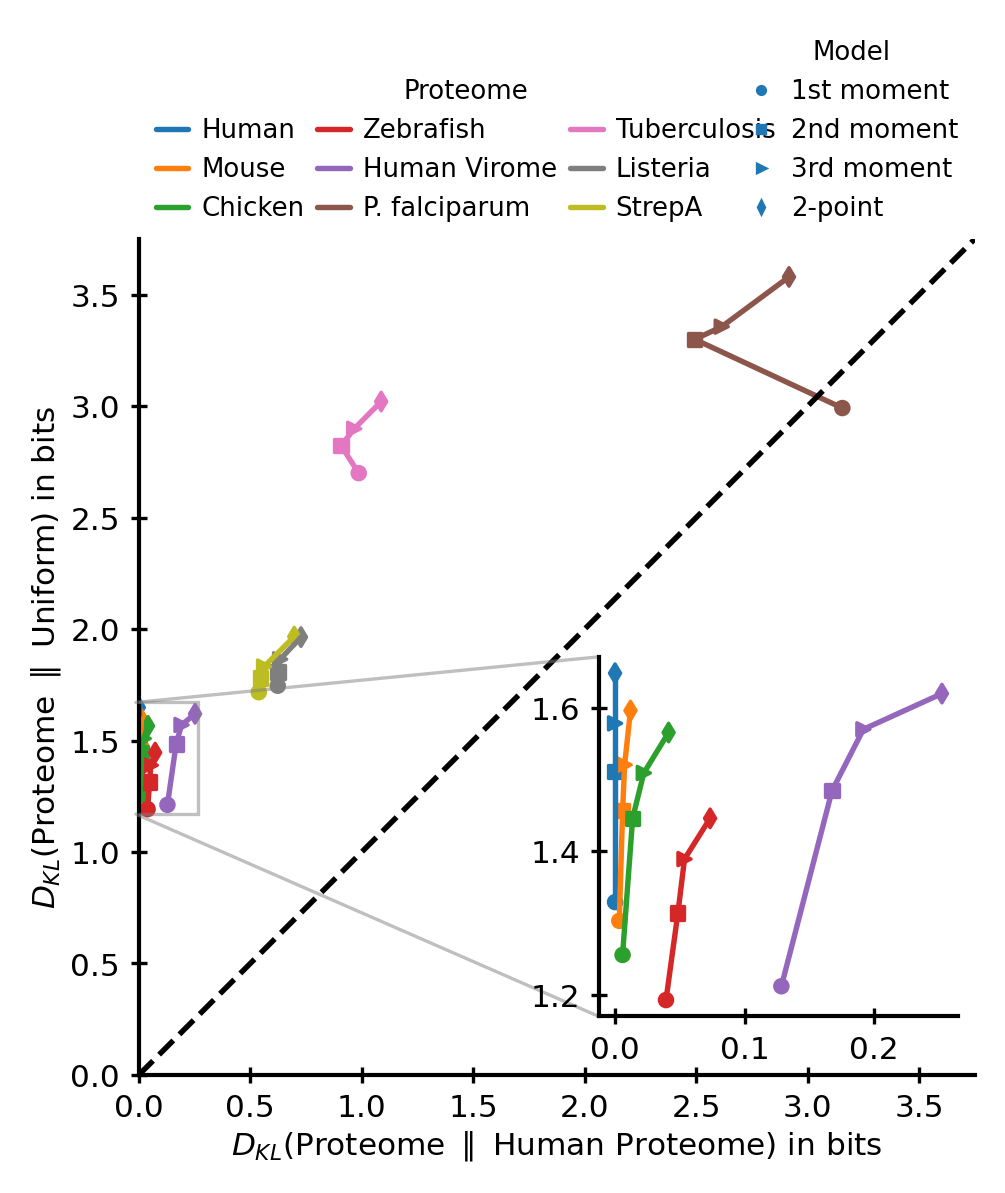

In [9]:
nattobits = np.log2(np.exp(1))
lim = 2.6*nattobits
fig, ax = plt.subplots(figsize=(3.42, 4.0))
for proteome in proteomes:
    l, sc, legend_handles = plot_lineandscatter(dkls.loc[proteome]*nattobits,
                                                dkls_rand.loc[proteome]*nattobits,
                                                label=proteome_to_label[proteome],
                                                ax=ax)
ax.plot([0, lim], [0, lim], 'k--')
l1 = ax.legend(ncol=3, loc='lower left',
               title='Proteome', bbox_to_anchor=(0.0, 1.0))
l2 = ax.legend(legend_handles, [model_labels[m] for m in models],
               loc='lower right', title='Model', ncol=1, bbox_to_anchor=(1.0, 1.0))
ax.add_artist(l1)
ax.set_xlim(-0.0, lim)
ax.set_ylim(-0.0, lim)
ax.set_xlabel('$D_{KL}$(Proteome $\parallel$ Human Proteome) in bits')
ax.set_ylabel('$D_{KL}$(Proteome $\parallel$ Uniform) in bits')
ax.set_aspect('equal')

axins = ax.inset_axes((0.55, 0.07, 0.43, 0.43))
for proteome in ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses']:
    plot_lineandscatter(dkls.loc[proteome]*nattobits, dkls_rand.loc[proteome]*nattobits, label=proteome, ax=axins)
rectangle_patch, connector_lines = ax.indicate_inset_zoom(axins)
#lower_left, upper_left, lower_right, upper_right = connector_lines

fig.tight_layout()
# fig.savefig(figuredir + 'dkls.svg')


In [10]:
proteome = 'Humanviruses'
all_data = {}
for i, model in enumerate(['independent', 'ncov', 'nskew', 'nskewfcov']):

    arr = np.load(f'../data/generated_data/{proteome}_{model}_likelihoods.npz')
    data = {}

    logp_hh, logp_pp, logp_hp, logp_ph = arr['logp_hh'], arr['logp_pp'], arr['logp_hp'], arr['logp_ph']
    data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph'] = logp_hh, logp_pp, logp_hp, logp_ph

    positive = logp_pp-logp_ph
    negative = logp_hp-logp_hh#[np.random.randint(len(logp_hh), size=len(positive)*negative_excess)]
    y_true = np.concatenate([np.ones(len(positive)), np.zeros(len(negative))])
    y_score = np.concatenate([positive, negative])
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    data['fpr'], data['tpr'], data['roc_auc'] = fpr, tpr, roc_auc
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    data['precision'], data['recall'], data['average_precision'] = precision, recall, average_precision

    all_data[model] = data
negative_excess = len(logp_hh)/len(logp_pp)

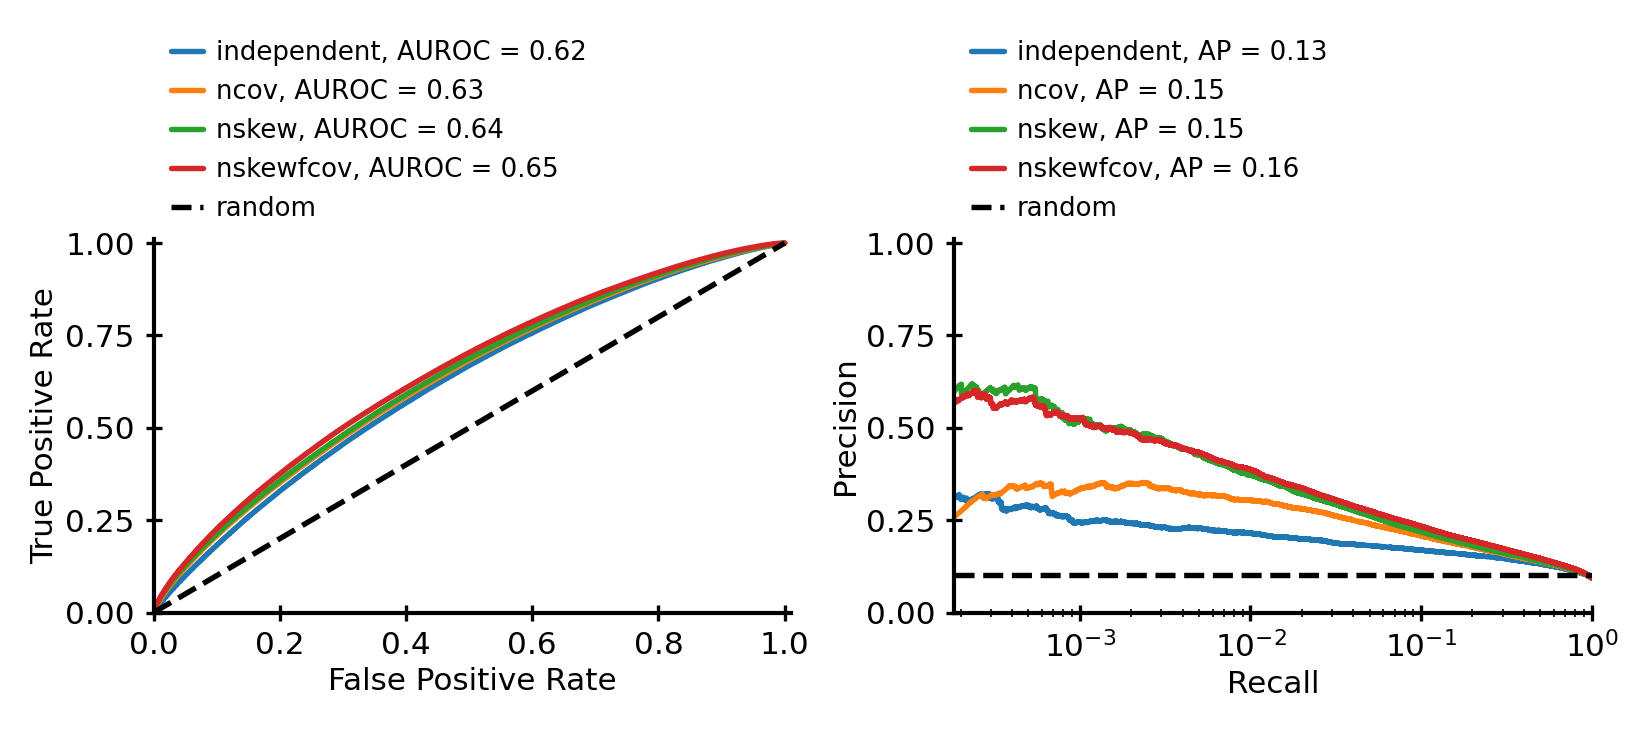

In [11]:
fig, axes = plt.subplots(figsize=(5.5, 2.5), ncols=2, nrows=1)


plot_kwargs = dict()#lw=0.8

ax = axes[0]
for model, data in all_data.items():
    ax.plot(data['fpr'], data['tpr'],
            label='{model}'.format(model=model)+', AUROC = %0.2f' % data['roc_auc'],
            **plot_kwargs)
ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='random')
ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.0))

ax = axes[1]
for model, data in all_data.items():
    ax.plot(data['recall'], data['precision'],
            label='{model}'.format(model=model)+', AP = {0:0.2f}'.format(data['average_precision']),
            **plot_kwargs)
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(1.0/negative_excess, c='k', ls='--', label='random')
ax.set_ylim(0.0, 1.01)
#ax.set_xlim(0.0, 1.01)
ax.set_xscale('log')
ax.set_xticks(10.0**np.arange(-4, 1, 1))
ax.set_xlim(100/len(logp_pp), 1.0)
ax.legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))

fig.tight_layout()


In [12]:
nattobits = lambda x: x*np.log2(np.exp(1))

In [13]:
df = pd.read_csv('../data/Figure Data/nskewfcov_k9_dkls_pairwise.csv',index_col=0)
df.loc[-1]=({'proteome': 'Uniform','reference':'Uniform','DKL':0.0})
proteomes = list(df['proteome'].unique())
N = len(proteomes)
matrix = np.empty((N,N))
for i in range(N):
    for j in range(N):
        if i==j:
            dkl = 0
        else:
            first = proteomes[i]
            second = proteomes[j]
            dkl = float(df[(df['proteome']==first)&(df['reference']==second)]['DKL'].values[0])
        matrix[i,j] = nattobits(dkl)

                               

In [14]:
print('Original Dimension of X : ', matrix.shape)


Original Dimension of X :  (13, 13)


In [15]:
J = 0.5 * (matrix + matrix.T) # symmetrize it


In [16]:
mds = MDS(n_components=2, random_state=22,dissimilarity="precomputed")
X_2d = mds.fit_transform(J)

In [17]:
print('Dimension of X after MDS : ', X_2d.shape)

Dimension of X after MDS :  (13, 2)


In [18]:
coloring = {
    'Mouse': '#ff7f0e',
    'Chicken': '#2ca02c',
    'Zebrafish': '#d62728',
    'Humanviruses': '#9467bd',
    'Malaria': '#8c564b',
    'Tuberculosis': '#e377c2',
    'Listeria': '#7f7f7f',
    'StrepA': '#bcbd22',
    'Uniform': 'black',
    'Human':'tab:blue',
    'Rice': 'pink',
    'Wheat': 'cyan',
    'Soybean': 'magenta'
}

[Text(0, -1.5, ''),
 Text(0, -1.0, ''),
 Text(0, -0.5, ''),
 Text(0, 0.0, ''),
 Text(0, 0.5, ''),
 Text(0, 1.0, ''),
 Text(0, 1.5, ''),
 Text(0, 2.0, '')]

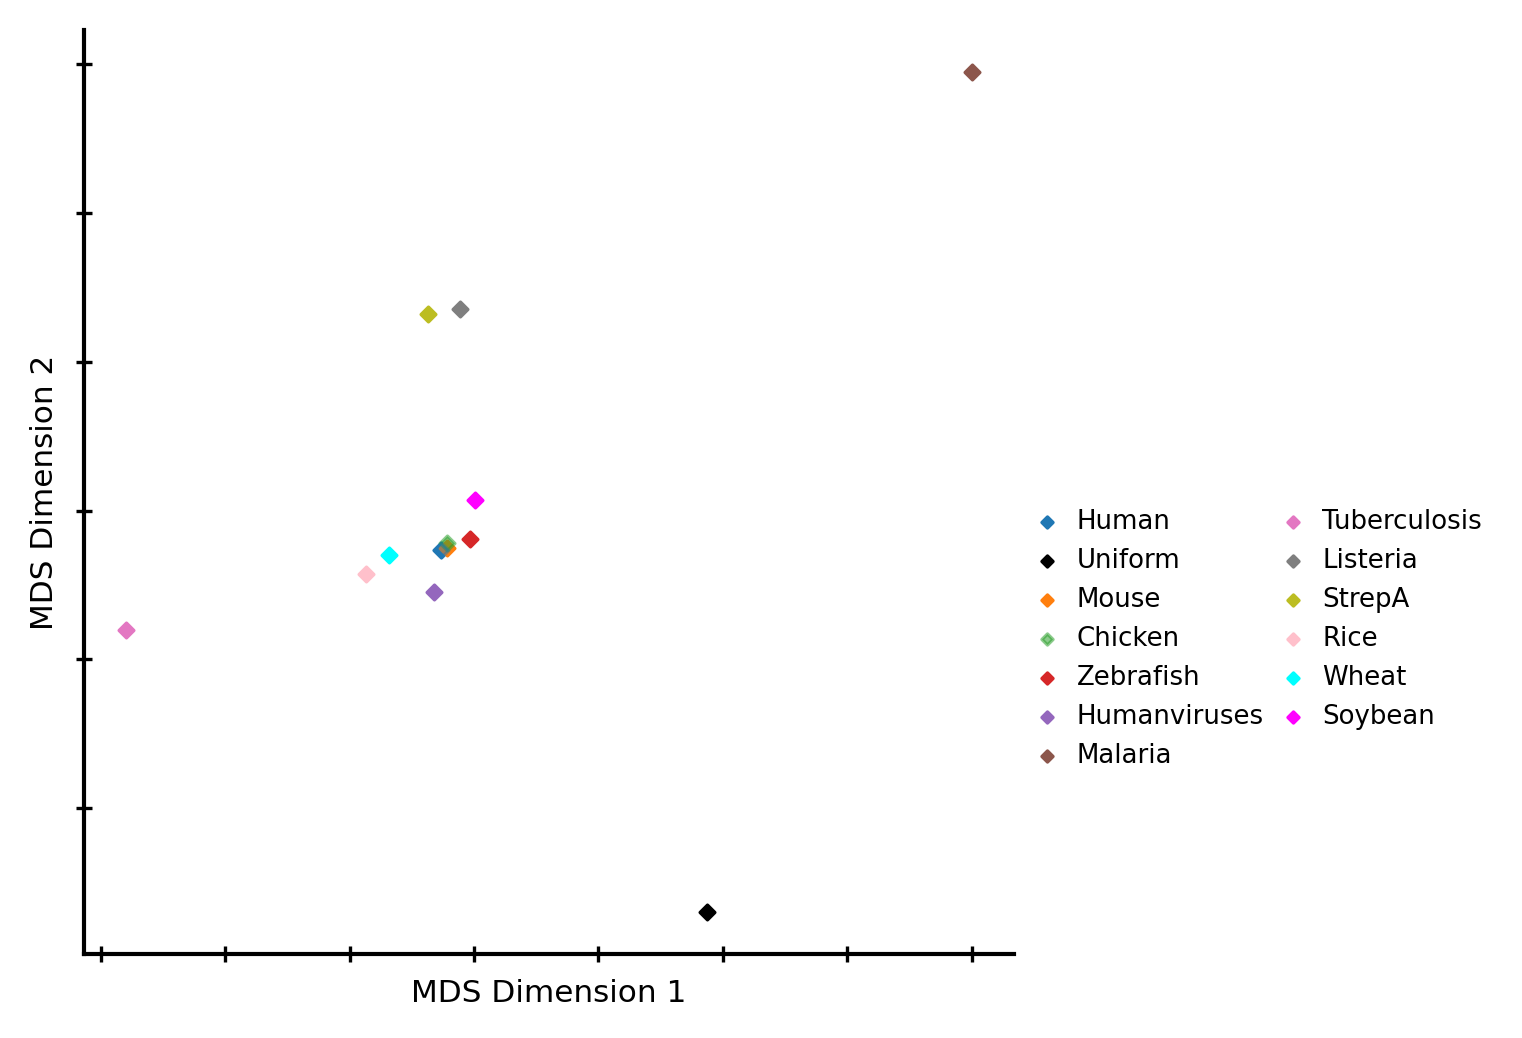

In [19]:
fig, ax = plt.subplots(figsize=(4,4))
L = X_2d.shape[0]

for i in range(L):
    x = X_2d[i,0]
    y = X_2d[i,1]
    if proteomes[i] =='Chicken':
        alpha=.55
    elif proteomes[i] =='Mouse':
        alpha=1
    else:
        alpha=1
    ax.scatter(x,y,marker='D',alpha=alpha,color=coloring[proteomes[i]],label=proteomes[i])

# replot human dot so it is on top
i=0
x = X_2d[i,0]
y = X_2d[i,1]
ax.scatter(x,y,marker='D',alpha=.45,color=coloring[proteomes[i]])
ax.legend(ncols=2,loc='upper left',bbox_to_anchor=(1,.5))
ax.set_xlabel("MDS Dimension 1")
ax.set_ylabel("MDS Dimension 2")
ax.set_xticklabels([])
ax.set_yticklabels([])

In [20]:
# redo analyis but remove plants from analysis, since they are not included in the paper
df = pd.read_csv('../data/Figure Data/nskewfcov_k9_dkls_pairwise.csv',index_col=0)
plants = {'Wheat','Soybean','Rice'}
df = df[~df['proteome'].isin(plants)]
df = df[~df['reference'].isin(plants)]

In [21]:
nattobits = lambda x: x*np.log2(np.exp(1))

In [22]:
df.loc[-1]=({'proteome': 'Uniform','reference':'Uniform','DKL':0.0})

In [23]:
proteomes = list(df['proteome'].unique())
N = len(proteomes)

In [24]:
matrix = np.empty((N,N))
for i in range(N):
    for j in range(N):
        if i==j:
            dkl = 0
        else:
            first = proteomes[i]
            second = proteomes[j]
            dkl = float(df[(df['proteome']==first)&(df['reference']==second)]['DKL'].values[0])
        matrix[i,j] = nattobits(dkl)

                               

In [25]:
J = 0.5 * (matrix + matrix.T)

In [26]:
mds = MDS(n_components=2, random_state=22,dissimilarity="precomputed")
X_2d = mds.fit_transform(J)

In [27]:
coloring = {
    'Mouse': '#ff7f0e',
    'Chicken': '#2ca02c',
    'Zebrafish': '#d62728',
    'Human Virome': '#9467bd',
    'P. falciparum': '#8c564b',
    'Tuberculosis': '#e377c2',
    'Listeria': '#7f7f7f',
    'StrepA': '#bcbd22',
    'Uniform': 'black',
    'Human':'tab:blue',
}

In [28]:
model_labels

{'train': 'training set',
 'model': '2-point',
 'model_ncov': '2nd moment',
 'model_nskew': '3rd moment',
 'model_nskewdiag': '3rd moment diag',
 'model_nskewfcov': '3rd moment, 2-point',
 'uniform': 'uniform',
 'test': 'test set',
 'independent': '1st moment',
 'ncov': '2nd moment',
 'nskew': '3rd moment',
 'nskewfcov': '2-point'}

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1389692/821026933.py:20: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$D_{KL}$(Proteome $\parallel$ Human Proteome) in bits')
/tmp/ipykernel_1389692/821026933.py:21: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$D_{KL}$(Proteome $\parallel$ Uniform) in bits')


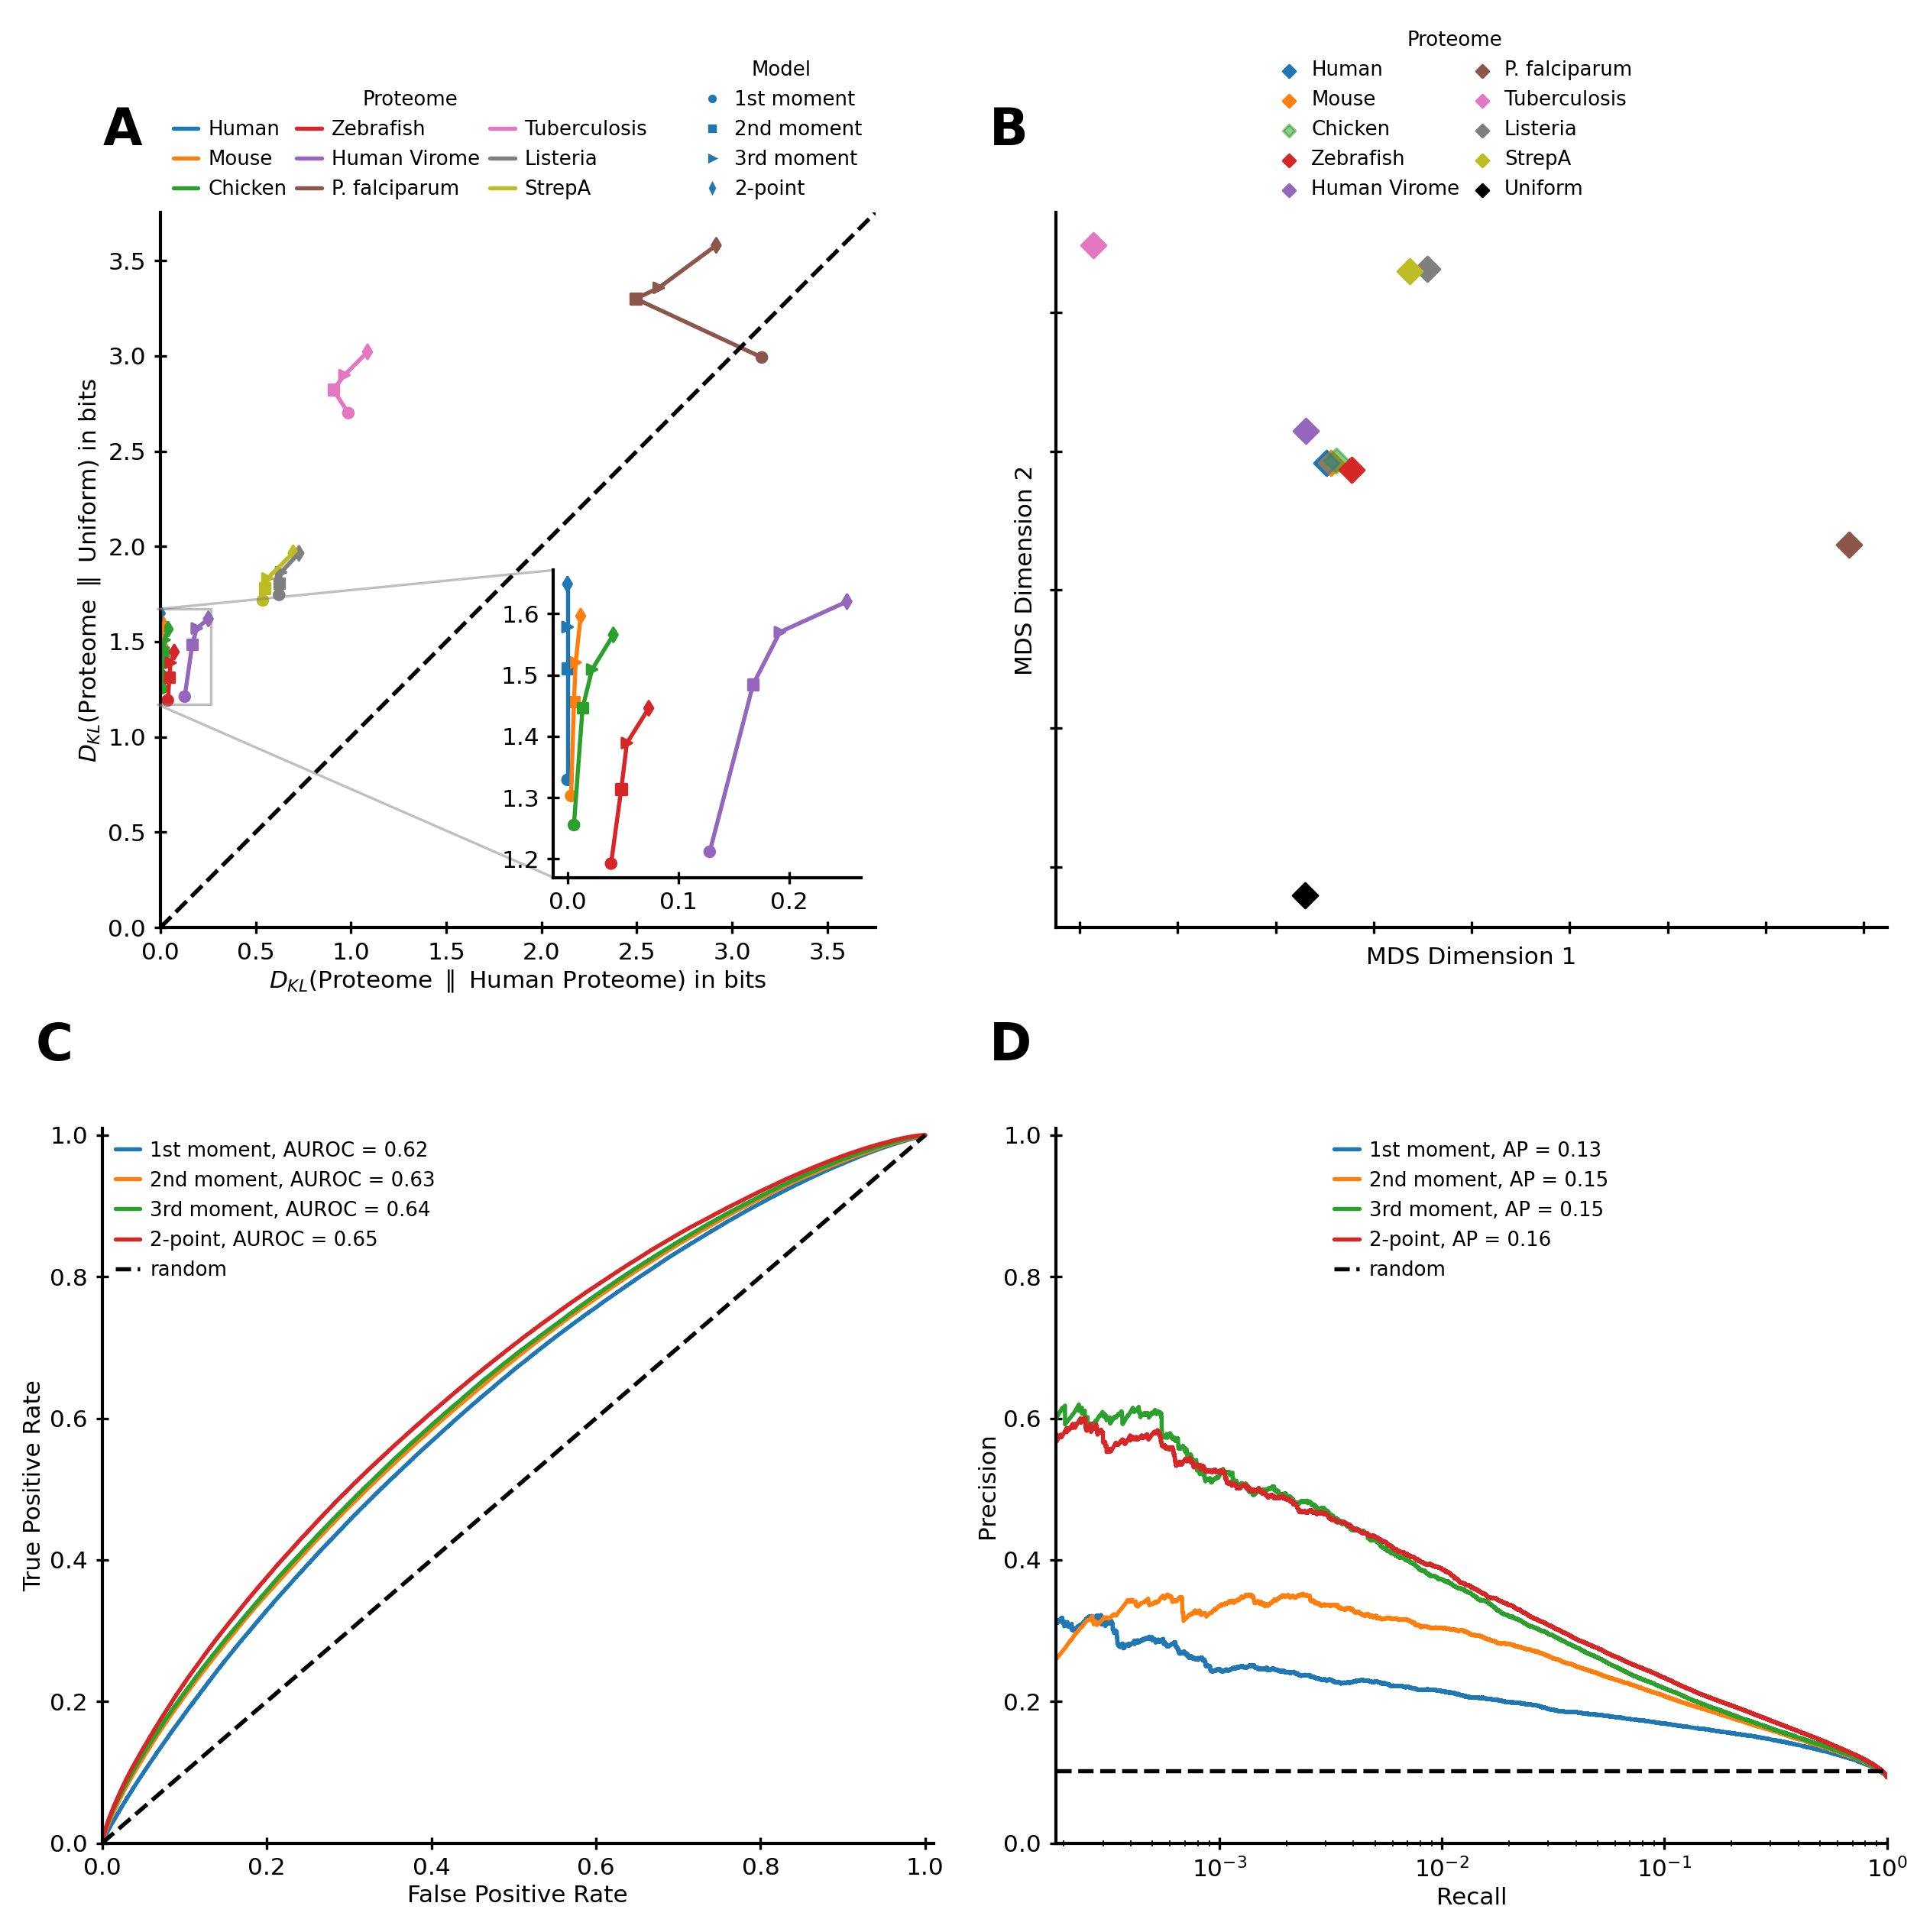

In [29]:
proteomes = ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses', 'Malaria', 'Tuberculosis', 'Listeria', 'StrepA', ]

nattobits = np.log2(np.exp(1))
lim = 2.6*nattobits
fig, axes = plt.subplots(2,2,figsize=(8.5, 8.5))
ax = axes[0,0]
for proteome in proteomes:
    l, sc, legend_handles = plot_lineandscatter(dkls.loc[proteome]*nattobits,
                                                dkls_rand.loc[proteome]*nattobits,
                                                label=proteome_to_label[proteome],
                                                ax=ax)
ax.plot([0, lim], [0, lim], 'k--')
l1 = ax.legend(ncol=3, loc='lower left',
               title='Proteome', bbox_to_anchor=(0.0, 1.0))
l2 = ax.legend(legend_handles, [model_labels[m] for m in models],
               loc='lower right', title='Model', ncol=1, bbox_to_anchor=(1.0, 1.0))
ax.add_artist(l1)
ax.set_xlim(-0.0, lim)
ax.set_ylim(-0.0, lim)
ax.set_xlabel('$D_{KL}$(Proteome $\parallel$ Human Proteome) in bits')
ax.set_ylabel('$D_{KL}$(Proteome $\parallel$ Uniform) in bits')
ax.set_aspect('equal')

axins = ax.inset_axes((0.55, 0.07, 0.43, 0.43))
for proteome in ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses']:
    plot_lineandscatter(dkls.loc[proteome]*nattobits, dkls_rand.loc[proteome]*nattobits, label=proteome, ax=axins)
rectangle_patch, connector_lines = ax.indicate_inset_zoom(axins)
#lower_left, upper_left, lower_right, upper_right = connector_lines



desired_order = proteomes + ["Uniform"]
desired_order = [proteome_to_label.get(p,p) for p in desired_order]
proteomes = list(df['proteome'].unique())
proteomes = [proteome_to_label.get(p,p) for p in proteomes]

ax = axes[0,1]
L = X_2d.shape[0]

for i in range(L):
    x = X_2d[i,0]
    y = X_2d[i,1]
    if proteomes[i] =='Chicken':
        alpha=.55
    elif proteomes[i] =='Mouse':
        alpha=1
    else:
        alpha=1
    ax.scatter(x,y,marker='D',s=30,label=proteomes[i],alpha=alpha,color=coloring[proteomes[i]])

handles, labels = ax.get_legend_handles_labels()
order_map = {label: i for i, label in enumerate(labels)}
handles = [handles[order_map[l]] for l in desired_order]

ax.legend(handles, desired_order,ncol=2, loc='lower left',markerscale=.5,
               title='Proteome', bbox_to_anchor=(0.25, 1))

# replot human dot so it is on top
i=0
x = X_2d[i,0]
y = X_2d[i,1]
ax.scatter(x,y,marker='D',alpha=.5,s=30,color=coloring[proteomes[i]])

ax.set_xlabel("MDS Dimension 1")
ax.set_ylabel("MDS Dimension 2")
ax.set_xticklabels([])
ax.set_yticklabels([])




plot_kwargs = dict()#lw=0.8

ax = axes[1,0]
for model, data in all_data.items():
    ax.plot(data['fpr'], data['tpr'],
            label=f'{model_labels[model]}, AUROC = {data["roc_auc"]:.2f}',
            **plot_kwargs)
ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='random')
ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="upper left")

ax = axes[1,1]
for model, data in all_data.items():
    ax.plot(
        data['recall'],
        data['precision'],
        label=f"{model_labels[model]}, AP = {data['average_precision']:.2f}",
        **plot_kwargs
    )
    ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(1.0/negative_excess, c='k', ls='--', label='random')
ax.set_ylim(0.0, 1.01)
#ax.set_xlim(0.0, 1.01)
ax.set_xscale('log')
ax.set_xticks(10.0**np.arange(-4, 1, 1))
ax.set_xlim(100/len(logp_pp), 1.0)
ax.legend(loc='upper center')


label_axes(fig,labelstyle='%s', xy=(-0.08, 1.15),fontsize=16)

fig.tight_layout()
# fig.savefig(figuredir + 'dkls.svg')
fig.savefig('../fig_2.pdf')

In [30]:
data['average_precision']

np.float64(0.16134768802743418)

In [31]:
proteomes

['Human',
 'Uniform',
 'Mouse',
 'Chicken',
 'Zebrafish',
 'Human Virome',
 'P. falciparum',
 'Tuberculosis',
 'Listeria',
 'StrepA']

In [32]:
order_map

{'Human': 0,
 'Uniform': 1,
 'Mouse': 2,
 'Chicken': 3,
 'Zebrafish': 4,
 'Human Virome': 5,
 'P. falciparum': 6,
 'Tuberculosis': 7,
 'Listeria': 8,
 'StrepA': 9}